## ДЗ №3: Рекуррентные нейронные сети.  Обработка естественного языка

### Пожалуйста, заполните имя

In [26]:
STUDENT_NAME = "Andrey Tomashev" # For example, Fedor Petriaikin

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from torch.nn import Parameter
from torch.nn import MSELoss
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать различные рекуррентные архитектуры для предсказания временного ряда и написания простейшего чат-бота.


### Часть 1. Предсказание временного ряда

а) Напишите свою реализацию LSTM
<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [28]:
# Кстати, на вход в pytorch-реализацию можно подавать последовательности разной длины.
# См. torch.nn.utils.rnn.pack_padded_sequence() и torch.nn.utils.rnn.pack_sequence()
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTM, self).__init__()
        ## YOUR CODE HERE
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_ii = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hi = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = Parameter(torch.Tensor(hidden_size))
        self.W_if = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hf = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = Parameter(torch.Tensor(hidden_size))
        self.W_ig = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hg = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = Parameter(torch.Tensor(hidden_size))
        self.W_io = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_ho = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()
        
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
    
    # Пропускает через себя последовательность и выдает последний выход
    # X: (seq_len, batch_size, input_size)
    # hidden = (hidden, C): (batch_size, hidden_size)x2 - чтобы начать предсказания с какого-то момента
    # Если None, инициализировать нулями
    # Возвращает out, h, c, где (h, c) - выход и скрытое состояние после последнего элемента
    # out - (seq_len, batch, hidden_size) - выходы каждого слоя
    def forward(self, X, hidden=None):
        seq_len, batch_size, input_size = X.shape
        X = X.reshape(X.shape[1], X.shape[0], X.shape[2])
        hidden_seq = []
        if hidden is None:
            h_t, c_t = torch.zeros(self.hidden_size).to(X.device), torch.zeros(self.hidden_size).to(X.device)
        else:
            h_t, c_t = hidden[0], hidden[1]
            
        for t in range(seq_len): 
            x_t = X[:, t, :]
            i_t = torch.sigmoid(x_t @ self.W_ii + h_t @ self.W_hi + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_if + h_t @ self.W_hf + self.b_f)
            g_t = torch.tanh(x_t @ self.W_ig + h_t @ self.W_hg + self.b_g)
            o_t = torch.sigmoid(x_t @ self.W_io + h_t @ self.W_ho + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim = 0)
        return hidden_seq, (h_t, c_t)

б) Напишите код обучения LSTM на представленных данных

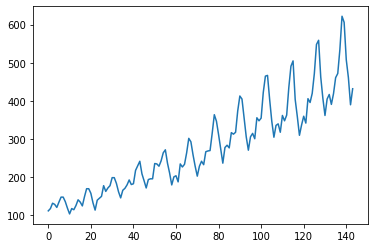

In [29]:
# График (*)
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [30]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [31]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [32]:
# Целевая переменная - сдвинутая последовательность значений входов
# look_back - на сколько смещен test относительно train (seq_len)
# look_forward - сколько нужно предсказать
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])
    return np.array(dataX), np.array(dataY)

In [33]:
# Пример подготовленных данных
look_back = 5
look_forward= 1

trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [34]:
class AirlineDataset(Dataset):
    def __init__(self, data, look_back = 1, look_forward = 1):
        X, self.dataY = create_dataset(data, look_back, look_forward)
        self.dataX = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    def __len__(self):
        return len(self.dataX)
    
    def __getitem__(self, idx):
        dataX = self.dataX[idx]
        dataY = self.dataY[idx]
        
        return dataX, dataY

In [35]:
train_dataset    = AirlineDataset(data = train, look_back = 5, look_forward = 1)
train_dataloader = DataLoader(train_dataset, batch_size = 1,
                              shuffle=False)
test_dataset    = AirlineDataset(data = test, look_back = 5, look_forward = 1)
test_dataloader = DataLoader(test_dataset, batch_size = 1,
                              shuffle=False)


In [39]:
class LSTM(nn.Module):
    def __init__(self, name, input_size = 1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        if(name == 'torch_lstm'):
            self.lstm = nn.LSTM(input_size, hidden_layer_size)
        elif (name == 'my_lstm'):
            self.lstm = MyLSTM(input_size, hidden_layer_size)
        elif (name == 'gru'):
            self.lstm = nn.GRU(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.name = name
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        
    
    
    # Пропускает через себя последовательность и выдает последний выход
    # X: (seq_len, batch_size, input_size)
    # hidden = (hidden, C): (batch_size, hidden_size)x2 - чтобы начать предсказания с какого-то момента
    # Если None, инициализировать нулями
    # Возвращает out, h, c, где (h, c) - выход и скрытое состояние после последнего элемента
    # out - (seq_len, batch, hidden_size) - выходы каждого слоя
    def forward(self, input_seq):
        if(self.name == 'gru'):
            lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1) , self.hidden_cell[0])
        else:
            lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1) , self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [40]:
# Берет данные из dataloader, сам их сдвигает, формируя обучающую выборку
# В качестве функции ошибок возьмите MSELoss, оптимизатор - Adagrad
# В функцию можно добавить дополнительные параметры (например, max_epochs, условия останова...)
def TrainModel(model, dataloader, look_back=5, look_forward=1, epochs = 1000):
    ## YOUR CODE HERE
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.004)
    mse_loss = MSELoss()
    loss_hist_train = []
    y_hist = []
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            for trainX, trainY in dataloader:
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                     torch.zeros(1, 1, model.hidden_layer_size))
                
                predY = model(trainX.squeeze())
                loss = mse_loss(predY, trainY.squeeze(1))
                if(epoch == epochs - 1):
                    y_hist.append(predY)
                loss.backward()
                optimizer.step()
            loss_hist_train.append(loss)
            pbar.update(1)
    
    fig = plt.figure()
    plt.title('train loss')
    plt.plot(range(len(loss_hist_train)), loss_hist_train)
    return y_hist

TORCH IMPLEMENTATION

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:36<00:00,  2.18it/s]


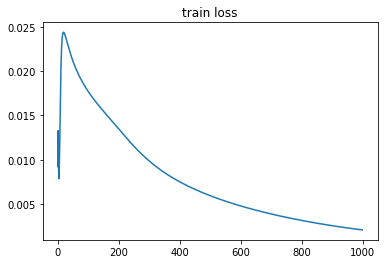

In [41]:
lstm_torch = LSTM('torch_lstm')
history = TrainModel(model = lstm_torch, dataloader = train_dataloader, look_back = 12, look_forward = 1)

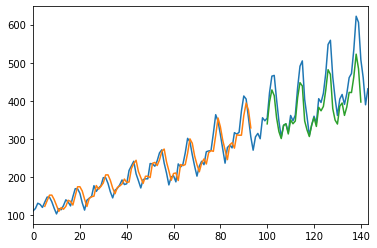

In [57]:
import math
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
trainPredict = scaler.inverse_transform(np.array(history).reshape(len(history), 1))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


testPredict = scaler.inverse_transform(np.array(y_test).reshape(len(y_test), 1))
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict)+look_back, :] = testPredict

x = np.arange(96, 144, 1)
plt.autoscale(axis='x', tight=True)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(x[4:45],testPredictPlot[5:46])
plt.show()

в) Попробуйте обучить сеть с разными параметрами look_back, look_forward. Также попробуйте использовать различные hidden_size. Выведите предсказания на график (\*). Сделайте вывод.  
*Обратите внимание*: "Классический", однонаправленный LSTM имеет размерность выхода (seq_len, batch, hidden_size). Но иногда нужно "изменить" размерность выхода - для этого можно обучить Linear: hidden_size x need_size  

г) Сравните свой результат и результат с использованием nn.LSTM (на аналогичном числе эпох, hidden_size и т.п.)  

д) Попробуйте использовать nn.GRU. Сравните результаты

MY LSTM

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:58<00:00,  1.51it/s]


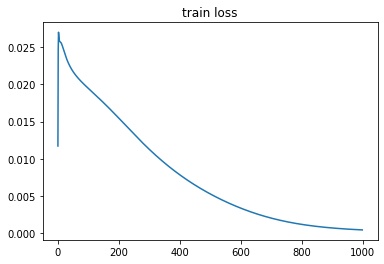

In [46]:
my_lstm = LSTM('my_lstm')
my_history = TrainModel(model = my_lstm, dataloader = train_dataloader, look_back = 12, look_forward = 1)

In [ ]:
my_lstm.eval()
my_y_test = []
with torch.no_grad():
    for a, b in test_dataloader:
        my_lstm.hidden_cell = (torch.zeros(1, 1, lstm_torch.hidden_layer_size),
                        torch.zeros(1, 1, lstm_torch.hidden_layer_size))
        y_pred_test = my_lstm(a.squeeze())
        my_y_test.append(y_pred_test)   

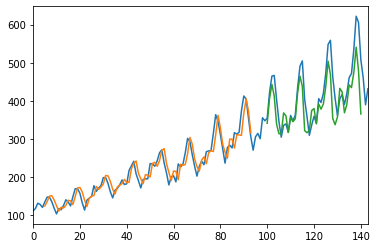

In [56]:
MytrainPredict = scaler.inverse_transform(np.array(my_history).reshape(len(my_history), 1))
MytrainPredictPlot = np.empty_like(dataset)
MytrainPredictPlot[:, :] = np.nan
MytrainPredictPlot[look_back:len(MytrainPredict)+look_back, :] = MytrainPredict

MytestPredict = scaler.inverse_transform(np.array(my_y_test).reshape(len(my_y_test), 1))
MytestPredictPlot = np.empty_like(dataset)
MytestPredictPlot[:, :] = np.nan
MytestPredictPlot[look_back:len(MytestPredict)+look_back, :] = MytestPredict

plt.autoscale(axis='x', tight=True)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(MytrainPredictPlot)
plt.plot(x[4:45],MytestPredictPlot[5:46])
plt.show()

GRU

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:31<00:00,  2.09it/s]


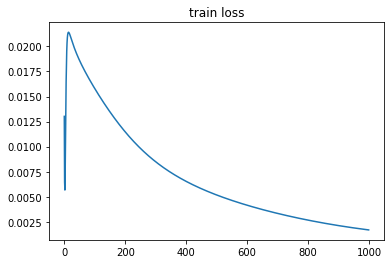

In [50]:
gru = LSTM('gru')
gru_history = TrainModel(model = gru, dataloader = train_dataloader, look_back = 12, look_forward = 1)

In [ ]:
gru.eval()
gru_y_test = []
with torch.no_grad():
    for a, b in test_dataloader:
        gru.hidden_cell = (torch.zeros(1, 1, lstm_torch.hidden_layer_size),
                      torch.zeros(1, 1, lstm_torch.hidden_layer_size))
        y_pred_test = gru(a.squeeze())
        gru_y_test.append(y_pred_test)

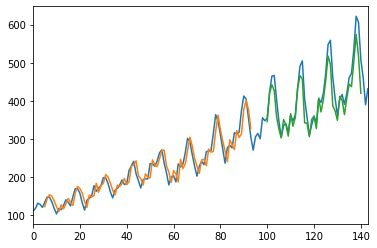

In [55]:
GRUtrainPredict = scaler.inverse_transform(np.array(gru_history).reshape(len(gru_history), 1))
GRUtrainPredictPlot = np.empty_like(dataset)
GRUtrainPredictPlot[:, :] = np.nan
GRUtrainPredictPlot[look_back:len(GRUtrainPredict)+look_back, :] = GRUtrainPredict

GRUtestPredict = scaler.inverse_transform(np.array(gru_y_test).reshape(len(gru_y_test), 1))
GRUtestPredictPlot = np.empty_like(dataset)
GRUtestPredictPlot[:, :] = np.nan
GRUtestPredictPlot[look_back:len(GRUtestPredict)+look_back, :] = GRUtestPredict

plt.autoscale(axis='x', tight=True)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(GRUtrainPredictPlot)
plt.plot(x[4:45],GRUtestPredictPlot[5:46])
plt.show()

### Часть 2. RNN и обработка текстов

В этом задании мы будем использовать файл author-quote.txt

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from torch.nn import Parameter
from torch.nn import MSELoss
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
import progressbar
import tqdm
%matplotlib inline

In [2]:
np.random.seed(777)
torch.random.manual_seed(777)

In [3]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]
# lines = [x.split('\t')[0].strip() for x in open('mama.txt',encoding='utf-8').readlines()]
lines[4]

'Weeds are flowers too, once you get to know them.'

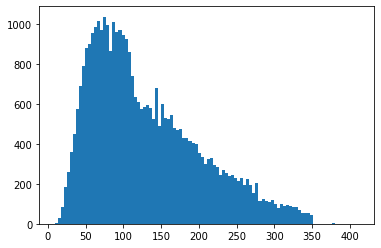

In [4]:
lines_len = []
for l in map(len, lines):
    lines_len.append(l)

plt.hist(lines_len, bins=100);

In [5]:
lines = [l for l in filter(lambda x: len(x) <= 50, lines)]

In [6]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.all_characters = all_characters
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])
    
vocab = Vocabulary(lines)

In [7]:
listok = vocab.all_characters
a = vocab.encode(listok)

In [8]:
vocab.char_to_id['<go>']

74

In [9]:
# <go>, <eos> - специальные токены начала и конца последовательности, нужны для работы предсказаний
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [10]:
# Для работы pack_padded_sequence
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [11]:
dataset = Quotes(lines, vocab)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

а) Напишите код класса Oracle

In [79]:
class Oracle(nn.Module):
    def __init__(self,name, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.name = name
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        if (name == 'gru'):
            self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        if (name == 'lstm'):
            self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
        self.softmax = nn.Softmax(dim=2)
                    
    # 1) Генерируем эмбединги входных токенов (из _input), пакуем в pack_padded_sequence, используя lengths
    # 2) Запускаем generator на эмбедингах, пакуем его вывод в pad_packed_sequence
    # 3) Возвращаем предикты (пока без SoftMax) через self.classifier
    
    def forward(self, _input, lengths):
        ## YOUR CODE HERE
        X = self.embedding(_input)
        X = torch.transpose(X, 0 ,1)
        X = nn.utils.rnn.pack_padded_sequence(X, lengths)
        X, _ = self.generator(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(X)
#         print(self.classifier(X).size())
        return self.classifier(X)

    
    
    # Генерирует последовательность (когда уже обучен). Токены переводим в id с помощью vocab.char_to_id,
    # обратно - с помощью vocab.id_to_char
    # Первый токен - <go>, делаем embeding. Далее generator -- classifier -- softmax.
    # Слово сэмплируем с помощью torch.distributions.Categorical, оно становится новым токеном
    # Повторяем, пока не будет <eos> или не достигнем max_len
    # Возвращаем - сгенерированную строку
    def generate(self, vocab, max_len=100):
        with torch.no_grad():
            string = []
            if(self.name == 'lstm'):
                h = (torch.zeros(self.layers, 1, self.hidden_size).cuda(),
                     torch.zeros(self.layers, 1, self.hidden_size).cuda())
            else:
                h = torch.zeros(self.layers, 1, self.hidden_size).cuda()
            X = vocab.char_to_id['<go>']
            for _ in range(max_len):
                X = torch.tensor([[X]], device = 'cuda')
                X = self.embedding(X)                        
                X, h = self.generator(X, h)
                X = self.classifier(X)
                
                soft = self.softmax(X)
                m = torch.distributions.Categorical(soft)
                char = vocab.id_to_char[m.sample().item()]
                X = vocab.char_to_id[char]
                
                if(char == '<eos>'):
                    break
                else:
                    string.append(char)
            
        return string

б) Обучите модель. Приведите примеры сгенеррованных предложений

In [80]:
oracle_lstm = Oracle('lstm',vocab.size, embedding_size=32, hidden_size=64, layers=2)
oracle_lstm.to(device='cuda')

Oracle(
  (embedding): Embedding(75, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=75, bias=True)
  (softmax): Softmax(dim=2)
)

In [81]:
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []
optimizer = torch.optim.Adagrad(oracle_lstm.parameters(), lr=0.01)

In [82]:
# Чтобы снизить колебания
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

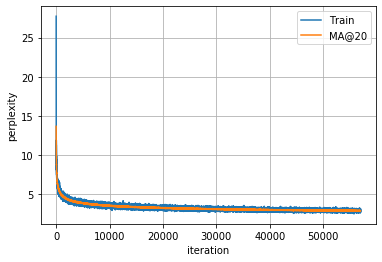

Starms to be suppally anly best plabal onsomagpionel.


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:02<00:00, 16.59it/s]


In [83]:
import progressbar
import tqdm
from IPython.display import clear_output

for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle_lstm.zero_grad()
#         oracle.hidden = torch.zeros(oracle.layers,go.size(0), oracle.hidden_size).cuda()
#         oracle_lstm.hidden = (torch.zeros(oracle_lstm.layers,go.size(0),oracle_lstm.hidden_size).cuda(),
#                               torch.zeros(oracle_lstm.layers,go.size(0),oracle_lstm.hidden_size).cuda())
        go = go.to('cuda')
        eos = eos.to('cuda')
        mask = mask.to('cuda')
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward(retain_graph = True)
        [x.grad.clamp_(-1, 1) for x in oracle_lstm.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
            string = ''.join(oracle_lstm.generate(vocab))
            print(string)
        

In [84]:
oracle_lstm.eval()
for _ in range(100):
    string = ''.join(oracle_lstm.generate(vocab))
    print(string)

I like women of two musit of love is my life?
The hers your people do it's people we polen.
Never resturs are with upporsent as hardement.
Praise, drove is planged.
Prusts in the were.
Be music is the film lection.
It's arome difference.
We don't need in our could are excuse Sutioused.
I am; betrealion word for enjoy.
Helle real things so divil well umseldoled rather.
Abophen is alraaderolition. I'm not it.
Really your popletice love bitany Conscivining life.
If you been hax artities tears.
Ins brey seather oubseres who I shoot to streng.
Conscciess is a Centrel' let forbot.
Denows sucrives the live differected of how slaml.
I'm not a plazy? Hate dayginaling light.
Whoboud works like a gomen generant.
I am a freedom, you gave fagan.
I was in the Demation was pensionfy.
My confess really hurrres.
Never came comb to be a sastar. Bereapter.
God ished Londist is of my family.
I give sunch a kils a distart.
Everything is peating fate.
You've guing my paxity.
My man is action.
I contthan I g

в) Обучить сеть с LSTM вместо GRU

г) Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох

д) Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

**Спасибо за выполнение заданий!**

In [85]:
oracle_gru = Oracle('gru',vocab.size, embedding_size=32, hidden_size=64, layers=2)
oracle_gru.to(device='cuda')

Oracle(
  (embedding): Embedding(75, 32)
  (generator): GRU(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=75, bias=True)
  (softmax): Softmax(dim=2)
)

In [86]:
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []
optimizer = torch.optim.Adagrad(oracle_gru.parameters(), lr=0.01)

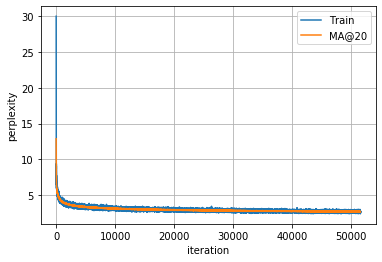

Gimit is a name, you vamries from more.
906


  7%|█████▊                                                                             | 4/57 [00:00<00:16,  3.23it/s]

In [ ]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle_gru.zero_grad()
        go = go.to('cuda')
        eos = eos.to('cuda')
        mask = mask.to('cuda')
        prediction = oracle_gru(go, length).transpose(0, 1).transpose(1, 2)
        
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward(retain_graph = True)
        [x.grad.clamp_(-1, 1) for x in oracle_gru.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
            string = ''.join(oracle_gru.generate(vocab))
            print(string)
            print(epoch)

In [ ]:
oracle_gru.eval()
for _ in range(100):
    string = ''.join(oracle_gru.generate(vocab))
    print(string)